In [20]:
# --- 必要ライブラリ ---
import os
import glob
import numpy as np
import matplotlib.pyplot as plt


In [21]:

%run ./func.ipynb


In [22]:
D, J = 100,100

# a side of the site
num_rows_columns = 50

alpha = 0
beta = 0.01

p = 2
r = 2

h_i = np.full(D, 1 / D)

# 既存のリーダーの施設セット J_L を仮定
J_L = {}  # インデックスとして候補施設の一部を選択
J_F = {}

fix_seed = False
eta = 0.01
mu = 0.05

max_iter = 500_000
tau_interval = 10000

In [23]:

# ============================================================
# 1) seeds（指定の10個）
# ============================================================
seeds = [
    3215657631,
    64559190,
    2234313259,
    1575315278,
    1841786322,
    59536268,
    3253077931,
    2276117799,
    2196164531,
    2645817242,
]

# ============================================================
# 2) ファイルパスの解決（eta, mu, iter, tau が分かるなら exact に。分からなければ wildcard で探索）
# ============================================================
BASE_DIR = "history"  # 適宜変更

def resolve_history_path(
    seed: int,
    *,
    eta: float | None = None,
    mu: float | None = None,
    max_iter: int | None = None,
    tau_interval: int | None = None,
    base_dir: str = BASE_DIR,
) -> str:
    """
    history/history_seed_{seed}_eta_{eta}_mu_{mu}_iter_{max_iter}_tau_{tau_interval}_exp.npz
    を優先して探す。指定パラメータが足りない場合は wildcard で seed に一致するものを探索。
    """
    if all(v is not None for v in [eta, mu, max_iter, tau_interval]):
        exact = os.path.join(
            base_dir,
            f"history_seed_{seed}_eta_{eta}_mu_{mu}_iter_{max_iter}_tau_{tau_interval}_exp.npz",
        )
        if os.path.exists(exact):
            return exact

    pattern = os.path.join(
        base_dir,
        f"history_seed_{seed}_eta_*_mu_*_iter_*_tau_*_exp.npz",
    )
    cand = glob.glob(pattern)
    if not cand:
        raise FileNotFoundError(f"seed={seed} の history が見つかりません: {pattern}")

    # 複数あったら更新日時が新しいものを採用（必要ならここを好みで変更）
    cand.sort(key=lambda p: os.path.getmtime(p), reverse=True)
    return cand[0]

def load_history_npz(path: str) -> dict:
    """np.savez(..., **history) で保存されている前提で dict に復元"""
    data = np.load(path, allow_pickle=True)
    hist = {k: data[k] for k in data.files}
    return hist

# ============================================================
# 3) gap_from_history を seeds 分回して res を集める
#    ※ p, r, h, J_L, J_F, alpha, beta, gap_from_history が事前に定義済みである前提
# ============================================================


In [24]:

# ---- ここはあなたの設定に合わせて調整 ----
stride   = 500
br_step  = 0.5
br_iters = 200

# もし eta, mu, max_iter, tau_interval が確定していて、ファイル名が一意なら入れてOK（None のままでもOK）
ETA = None
MU  = None
MAX_ITER = None
TAU_INTERVAL = None

results = {}   # seed -> res
paths   = {}   # seed -> path

for s in seeds:
    path = resolve_history_path(
        s,
        eta=ETA, mu=MU, max_iter=MAX_ITER, tau_interval=TAU_INTERVAL,
        base_dir=BASE_DIR
    )
    paths[s] = path

    history = load_history_npz(path)

    # history 内に demand_points / candidate_sites を入れているのでそれを使う
    demand_points   = history.get("demand_points", None)
    candidate_sites = history.get("candidate_sites", None)

    res = gap_from_history(
        history,
        p=p,
        r=r,
        h=h_i,
        # Ui_L / Ui_F を渡さない場合は J_L / J_F が必要
        J_L=J_L,
        J_F=J_F,
        # w を内部計算させる（demand_points / candidate_sites 必須）
        demand_points=demand_points,
        candidate_sites=candidate_sites,
        alpha=alpha,
        beta=beta,
        w=None,
        stride=stride,
        br_step=br_step,
        br_iters=br_iters,
        return_br=False,
    )

    results[s] = res

print("Loaded histories:")
for s in seeds:
    print(f"seed={s} -> {paths[s]}")



Loaded histories:
seed=3215657631 -> history\history_seed_3215657631_eta_0.01_mu_0.05_iter_500000_tau_10000_exp.npz
seed=64559190 -> history\history_seed_64559190_eta_0.01_mu_0.05_iter_500000_tau_10000_exp.npz
seed=2234313259 -> history\history_seed_2234313259_eta_0.01_mu_0.05_iter_500000_tau_10000_exp.npz
seed=1575315278 -> history\history_seed_1575315278_eta_0.01_mu_0.05_iter_500000_tau_10000_exp.npz
seed=1841786322 -> history\history_seed_1841786322_eta_0.01_mu_0.05_iter_500000_tau_10000_exp.npz
seed=59536268 -> history\history_seed_59536268_eta_0.01_mu_0.05_iter_500000_tau_10000_exp.npz
seed=3253077931 -> history\history_seed_3253077931_eta_0.01_mu_0.05_iter_500000_tau_10000_exp.npz
seed=2276117799 -> history\history_seed_2276117799_eta_0.01_mu_0.05_iter_500000_tau_10000_exp.npz
seed=2196164531 -> history\history_seed_2196164531_eta_0.01_mu_0.05_iter_500000_tau_10000_exp.npz
seed=2645817242 -> history\history_seed_2645817242_eta_0.01_mu_0.05_iter_500000_tau_10000_exp.npz


In [27]:
T_MAX = 400_000


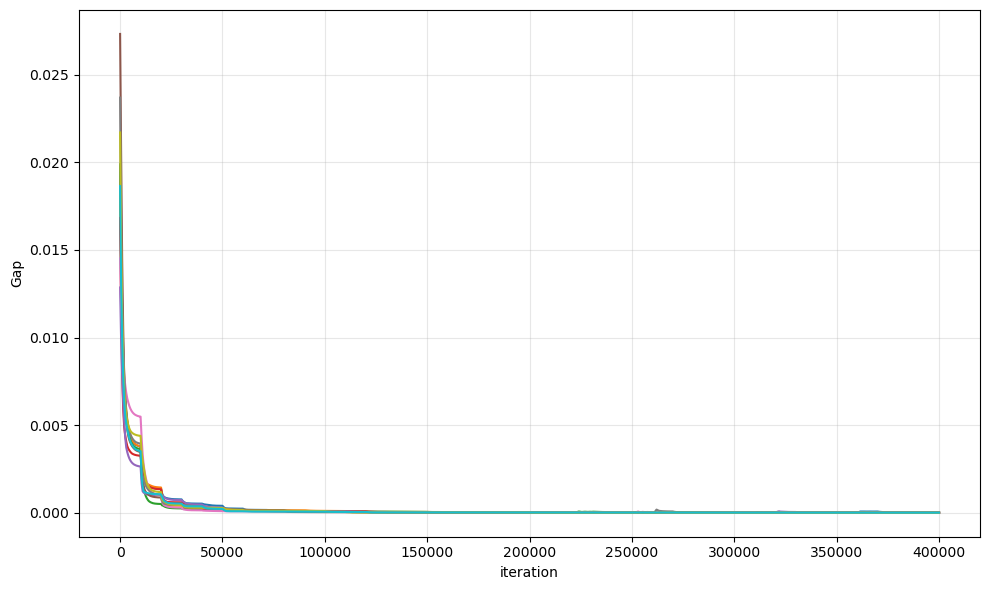


Final gap (smaller is better):
seed=2276117799: final_gap=1.45213e-06
seed=1575315278: final_gap=1.78737e-06
seed=64559190: final_gap=1.83267e-06
seed=2234313259: final_gap=2.14701e-06
seed=1841786322: final_gap=2.60978e-06
seed=3215657631: final_gap=2.63372e-06
seed=2645817242: final_gap=5.43158e-06
seed=3253077931: final_gap=5.49047e-06
seed=59536268: final_gap=5.66067e-06
seed=2196164531: final_gap=2.81967e-05


In [28]:
plt.figure(figsize=(10, 6))

for s in seeds:
    res = results[s]
    t = res["t"]
    gap = res["gap"]

    mask = (t <= T_MAX)
    plt.plot(t[mask], gap[mask], label=str(s), linewidth=1.5)

plt.xlabel("iteration")
plt.ylabel("Gap")
# plt.title("Gap(t) curves for 10 seeds")
plt.grid(True, alpha=0.3)
# plt.legend(title="seed", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()


plt.savefig(f"fig/plt_10_event_eta_{eta}_mu_{mu}_iter_{max_iter}_tau_{tau_interval}_exp_stride_{T_MAX}.png")
plt.show()
# ============================================================
# 5) （おまけ）最終ギャップの簡易比較
# ============================================================
final_gaps = [(s, float(results[s]["gap"][-1])) for s in seeds]
final_gaps.sort(key=lambda x: x[1])
print("\nFinal gap (smaller is better):")
for s, g in final_gaps:
    print(f"seed={s}: final_gap={g:.6g}")
